# Hybrid document search with VLM-1 and ChromaDB 

We're going to extend our workflow for finance presentations to incorporate Chroma, allowing us to store 
the embedded documents and extracted metadata simultaneously in a single data store for a variety of 
different retrieval flows. For instance, we'll be able to perform filtered language search using our schema.

As before, we're going to use slides from [SEC Edgar database](https://www.sec.gov/edgar.shtml).

## 0. Setup

In [12]:
# Install dependencies if needed
!pip install requests Pillow chromadb open-clip-torch

  Using cached open_clip_torch-2.24.0-py3-none-any.whl.metadata (30 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (7.7 kB)
  Using cached timm-0.9.16-py3-none-any.whl.metadata (38 kB)
Using cached open_clip_torch-2.24.0-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.0 MB/s eta 0:00:00
Using cached sentencepiece-0.2.0-cp311-cp311-macosx_10_9_x86_64.whl (1.2 MB)
Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)


## 1. `vlm` API

In this section, we will call the  `vlm-1` API using the Python `requests` library. We will use the `generate` endpoint of the API to extract visual information from the presentation slides.

Let's first test the `health` of the API.

In [3]:
import json
import os
import requests


VLM_BASE_URL = "https://vlm-dev.nos.run/v1"
response = requests.get(f"{VLM_BASE_URL}/health")
response.raise_for_status()
assert response.status_code == 200

## 2. List available models

Now, let's list the available models in the `vlm-1` API. If you are using the API for the first time, you may need to [sign up for an API key](typeform-link).

In [4]:
VLM_API_KEY = os.getenv("VLM_API_KEY", None)
if VLM_API_KEY is None:
    VLM_API_KEY = input()
print(f"Using API key: {VLM_API_KEY[:4]}...")

Using API key: sk-t...


In [5]:
headers = {
    "Content-Type": "application/json",
    "X-API-Key": VLM_API_KEY,
}
response = requests.get(f"{VLM_BASE_URL}/models", headers=headers)
response.raise_for_status()

In [6]:
print(json.dumps(response.json(), indent=2))

[
  {
    "model": "vlm-1",
    "domain": "tv.news"
  },
  {
    "model": "vlm-1",
    "domain": "document.presentation"
  },
  {
    "model": "vlm-1",
    "domain": "sports.nfl"
  },
  {
    "model": "vlm-1",
    "domain": "sports.nba"
  },
  {
    "model": "vlm-1",
    "domain": "sports.soccer"
  }
]


As we can see, there are two models available with the same base model `vlm-1` and different specializated versions (or domain-specific versions), namely `tv.news` and `document.presentation` for TV news and financial presentation understanding, respectively.

## 3. Extract information from financial presentations

First, let's define some helper functions to extract information from the financial presentations.

In [91]:
# %load ../vlm_tools/image.py
import json
from base64 import b64encode
from io import BytesIO
from typing import Literal, Union

import requests
from PIL import Image


def pprint(data):
    print(json.dumps(data, indent=2))


def encode_image(
    image: Image.Image, format: Literal["PNG", "JPEG"] = "PNG"
) -> Union[str, bytes]:
    """Convert an image to a base64 string."""
    buffered = BytesIO()
    image_format = image.format or format
    image.save(buffered, format=image_format)
    img_str = b64encode(buffered.getvalue()).decode()
    return f"data:image/{image_format.lower()};base64,{img_str}"


def download_image(url: str) -> Image.Image:
    """Download an image from a URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    }
    bytes = BytesIO(requests.get(url, headers=headers).content)
    bytes.seek(0)
    return Image.open(bytes).convert("RGB")


Finally, let's put together some helper functions to call the VLM API.

In [92]:
from pathlib import Path
from typing import Union

from PIL import Image
from IPython.display import display


def vlm(image: Image.Image, domain: str):
    """Send an image to the VLM API."""
    assert domain in ("tv.news", "document.presentation")
    data = {
        "model": "vlm-1",
        "domain": domain,
        "image": encode_image(image),
    }
    response = requests.post(f"{VLM_BASE_URL}/generate", headers=headers, json=data)
    response.raise_for_status()
    return response.json()


def vlm_visualize(image: Union[Image.Image, str, Path], domain: str):
    """Send an image to the VLM API and display the result."""
    if isinstance(image, str) and image.startswith("http"):
        image = download_image(image)
    elif isinstance(image, (str, Path)):
        if not Path(image).exists():
            raise FileNotFoundError(f"File not found {image}")
        image = Image.open(str(image)).convert("RGB")
    elif isinstance(image, Image.Image):
        image = image.convert("RGB")
    else:
        raise ValueError("Invalid image, must be a path, PIL Image or URL")

    display(image)
    result = vlm(image, domain)
    pprint(result)

In [93]:
URLS = [
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve001.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve002.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve003.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve004.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve005.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve006.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve007.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve008.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve009.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve010.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve011.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve012.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve013.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve014.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve015.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve016.jpg",
    
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve017.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve018.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve019.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve020.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve021.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve022.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve023.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve024.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve025.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve026.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve027.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve028.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve029.jpg",
    "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve030.jpg",
]

Now, let's extract some information from a financial presentation on [SEC EDGAR](https://www.sec.gov/edgar/search-and-access).

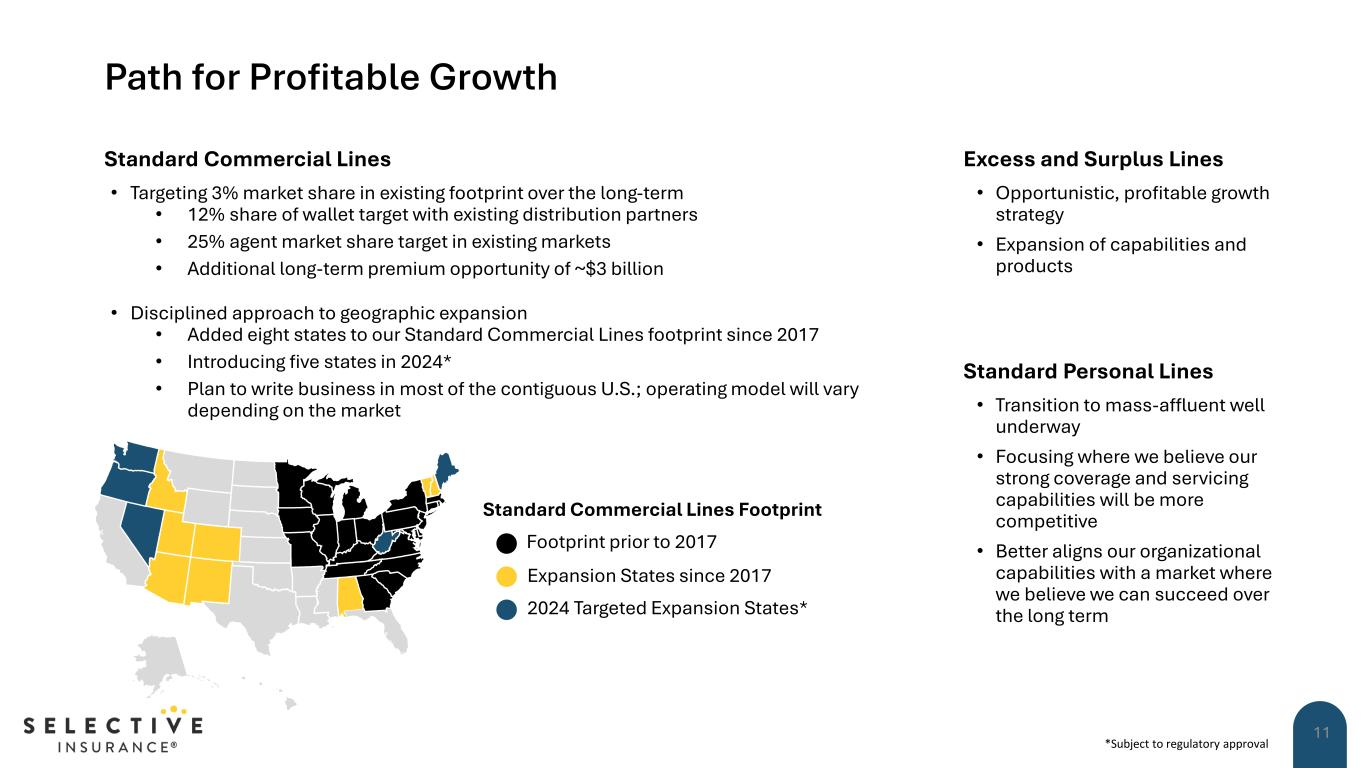

{
  "cls_name": "DocumentPresentationSlide-v1",
  "slide": "The slide presents a strategic plan titled 'Path for Profitable Growth', outlining the expansion and growth targets for Standard Commercial Lines, Excess and Surplus Lines, and Standard Personal Lines. It includes a map of the United States showing the company's commercial lines footprint.",
  "title": "Path for Profitable Growth",
  "page_number": 11,
  "plots": null,
  "tables": null,
  "others": [
    {
      "cls_name": "MarkdownBlock",
      "markdown": "### Standard Commercial Lines\n\n- Targeting 3% market share in existing footprint over the long-term\n  - 12% share of wallet target with existing distribution partners\n  - 25% agent market share target in existing markets\n  - Additional long-term premium opportunity of ~$3 billion\n- Disciplined approach to geographic expansion\n  - Added eight states to our Standard Commercial Lines footprint since 2017\n  - Introducing five states in 2024*\n  - Plan to write busines

In [94]:
url = URLS[10]
vlm_visualize(url, domain="document.presentation")

Ok, now lets set up our chroma DB and embed a few of these slides, then try out a language query.

In [95]:
import numpy as np
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import chromadb

client = chromadb.Client()

data_loader = ImageLoader()
embedding_function = OpenCLIPEmbeddingFunction()

collection = client.get_or_create_collection(
    name='earnings_slides', 
    embedding_function=embedding_function, 
    data_loader=data_loader)

url_base_ids = [url.split('/')[-1].split('.')[0] for url in URLS]

# Need to download the urls locally first:
url_paths = []
numpy_images = []
for url in URLS:
    image = download_image(url)
    url_path = url.split('/')[-1]
    image.save(f"{url_path}")
    url_paths.append(url_path)
    # convert PIL image to numpy
    numpy_images.append(np.array(image))

collection.add(
    ids = url_paths,
    images = numpy_images,
)


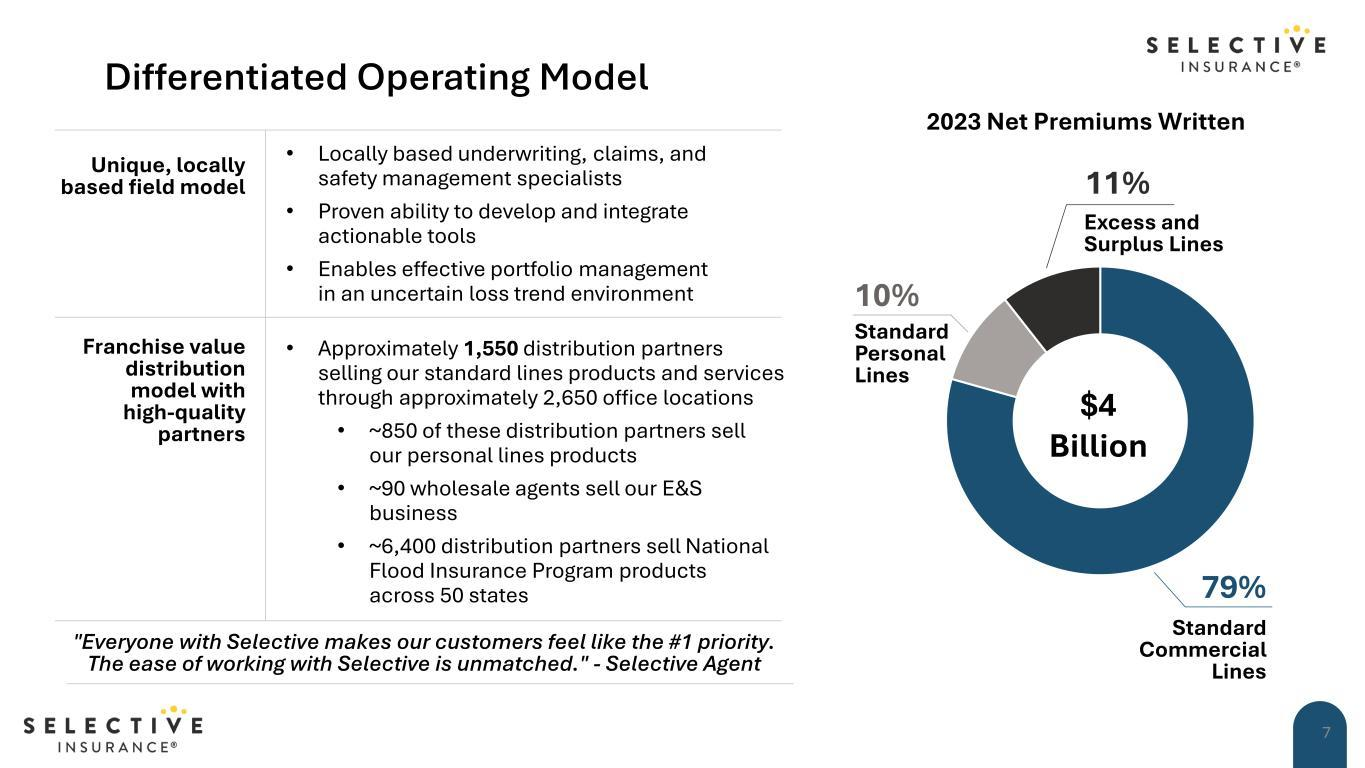

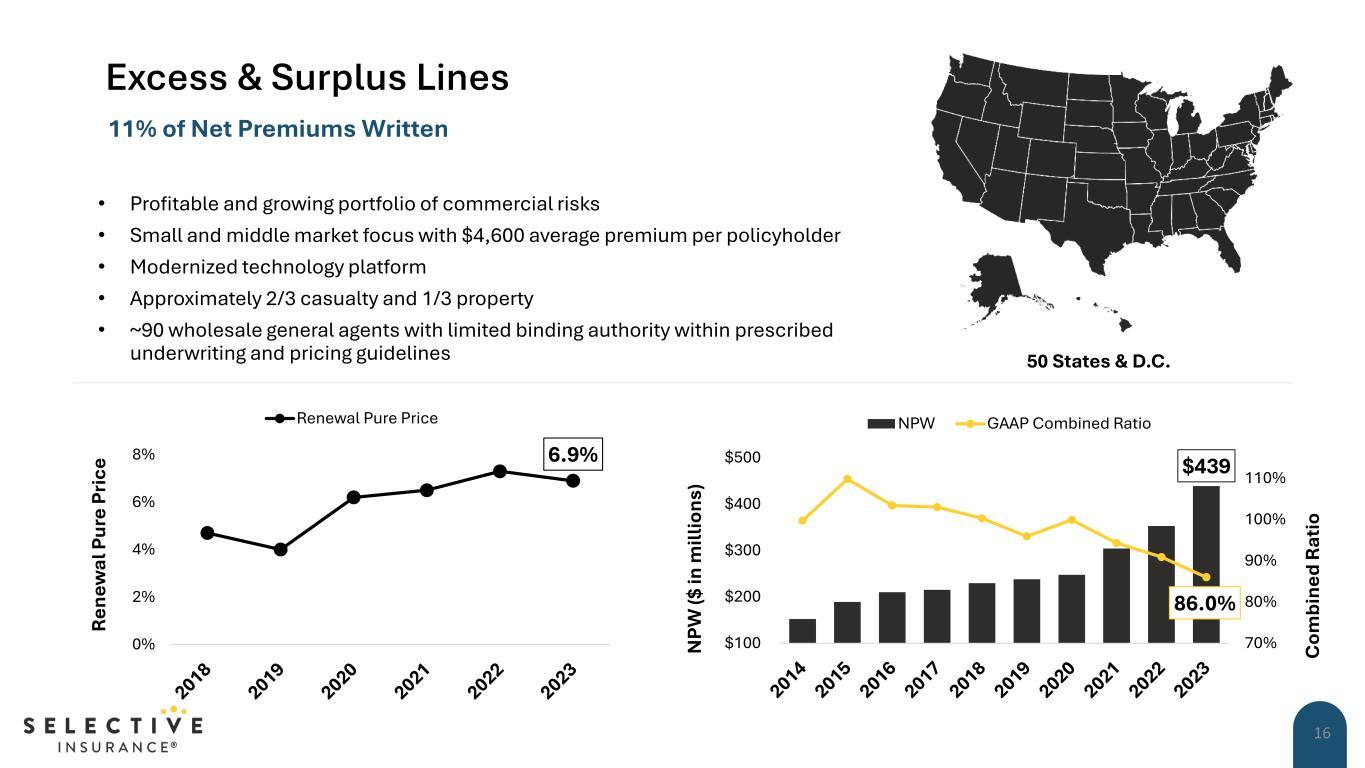

In [96]:
results = collection.query(
    query_texts=["DPW mix pie chart"]
)

# display the top result image
display(Image.open(results['ids'][0][0]))


results = collection.query(
    query_texts=["Net premiums written pie chart"]
)

# display the top result image
display(Image.open(results['ids'][0][0]))

While the top results for each query are somewhat reasonable, they aren't actually what we're looking for. The first query 'DPW mix pie chart' returns a slide containing a pie chart, just not the one we were looking for. The second query ('net premiums written pie chart') return a slide referencing net premiums (there are several in this deck) but not the specific pie chart we want. 

We can still make this work by incorporating metadata alongside our documents. Chroma supports filtering by metadata fields, which we can populate automatically with our API for Hybrid search. Let's ask VLM-1 to flag all of the documents containing a Pie Chart in the schema.

In [48]:

url_subset = URLS[5:15]
numpy_images_subset = numpy_images[5:15]

vlm_full_results = {}

for url in URLS:
    image = download_image(url)
    vlm_full_results[url] = vlm(image, domain="document.presentation")

In [84]:
# process the metadata to get the presence of absence of a pie chart

plot_metadata = {}
for key, result in vlm_full_results.items():
    plot_metadata[key] = {'has_pie_chart' : False}
    if result['plots'] is not None:
        for plot in result['plots']:
            if plot['type'] == 'pie':
                plot_metadata[key]['has_pie_chart'] = True

print(json.dumps(plot_metadata, indent=2))

{
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve001.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve002.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve003.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve004.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve005.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve006.jpg": {
    "has_pie_chart": false
  },
  "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve007.jpg": {
    "has_pie_chart": true
  },
  "https://www.sec.gov/Archives/edgar/da

Now we'll create a new collection, this time including our metadata dict alongside the vector for each document. We'll just ask for 'net premiums written' and filter by 'has_pie_chart' = True

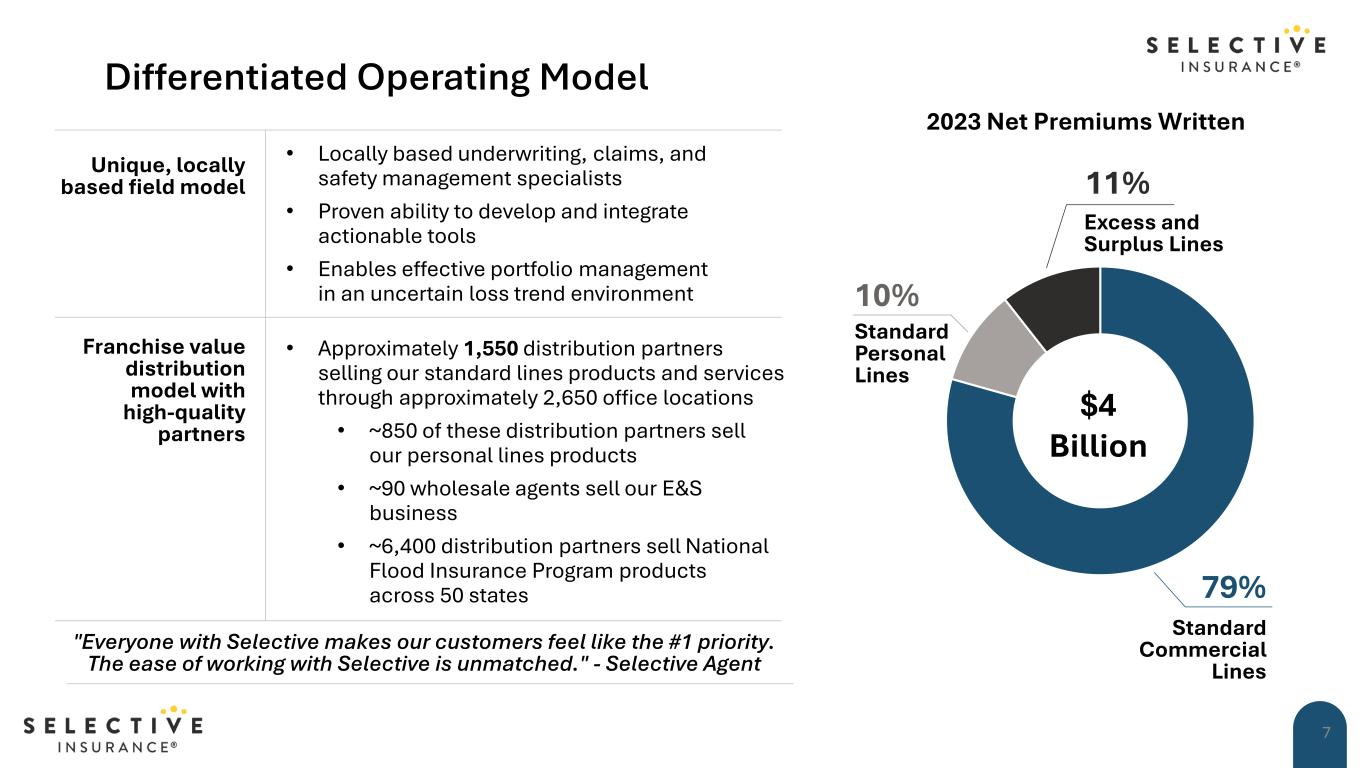

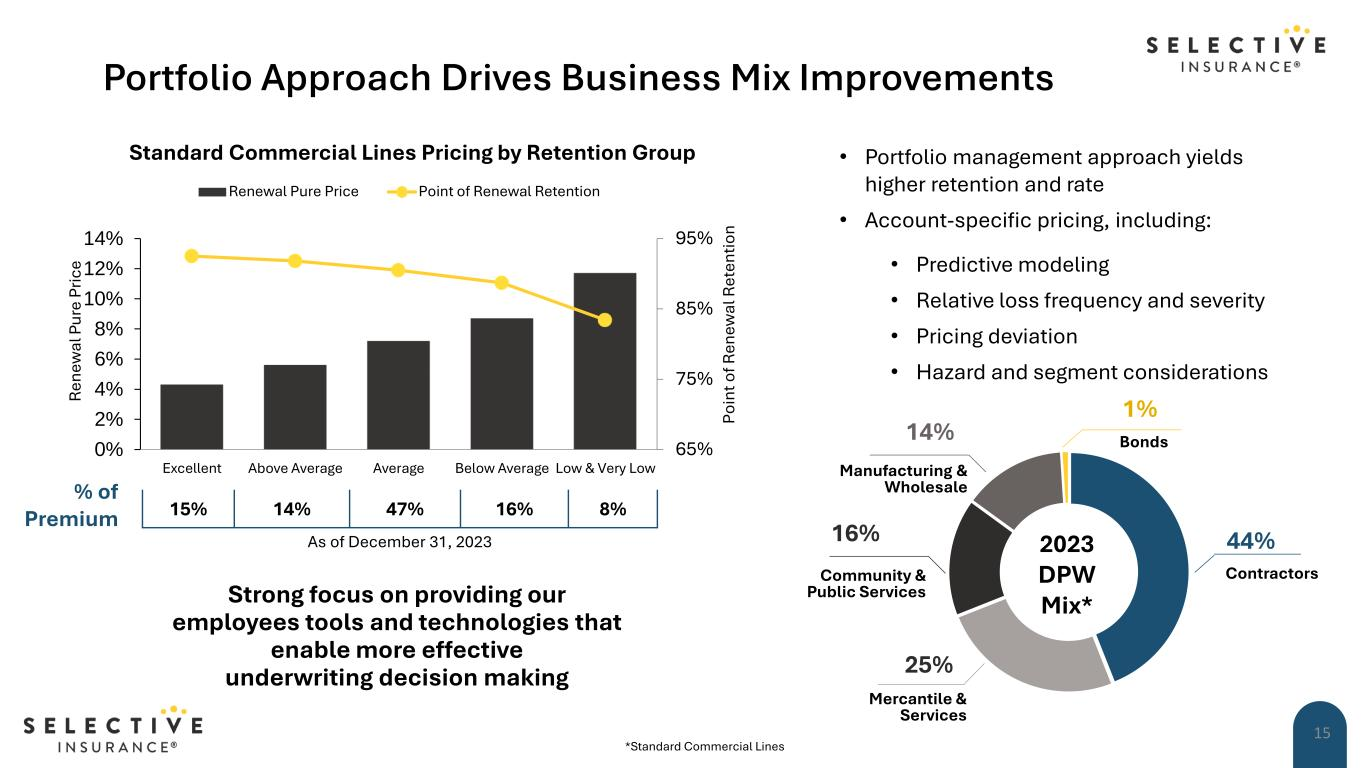

In [97]:
# Just using 10 slides to save time
url_subset = URLS[5:15]
numpy_images_subset = numpy_images[5:15]
metadata_subset = {key: value for key, value in plot_metadata.items() if key in url_subset}

collection = client.get_or_create_collection(
    name='earnings_slides_with_metadata', 
    embedding_function=embedding_function, 
    data_loader=data_loader)

collection.add(
    ids = url_subset,
    images = numpy_images_subset,
    metadatas = [value for value in metadata_subset.values()] # should be a list of dicts
)

results = collection.query(
    query_texts=["net premiums written"],
    where={"has_pie_chart" : True}
)

# display the top result image
top_1_image_id = results['ids'][0][0]
display(download_image(top_1_image_id))


results = collection.query(
    query_texts=["DPW Mix"],
    where={"has_pie_chart" : True}
)

# display the top result image
top_1_image_id = results['ids'][0][0]
display(download_image(top_1_image_id))

With only pie charts to pick from, we see the first and second results show pie charts for net premiums and DPW mix, respectively.